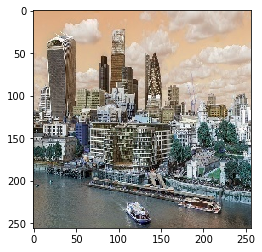

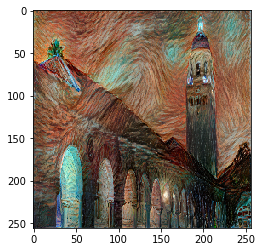

In [3]:
import cv2
import numpy as np
from scipy.optimize import fmin_l_bfgs_b

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from matplotlib import pyplot as plt

IMAGENET_RGB_VALUES = [123.68, 116.779, 103.939]

input_image=cv2.imread("Desktop/image.jpg")
input_image=cv2.resize(input_image,(256,256))

style_image=cv2.imread("Desktop/style.png")
style_image=cv2.resize(style_image,(256,256))

cv2.imwrite("Desktop/image.jpg",input_image)
cv2.imwrite("Desktop/style.png",style_image)

plt.imshow(input_image)
plt.show()

plt.imshow(style_image)
plt.show()

In [2]:
#Conversion to an array
i_arr=np.asarray(input_image,dtype="float32")
s_arr=np.asarray(style_image,dtype="float32")
i_arr=np.expand_dims(i_arr,axis=0)
s_arr=np.expand_dims(s_arr,axis=0)
print(i_arr.shape)
print(s_arr.shape)

(1, 256, 256, 3)
(1, 256, 256, 3)


In [3]:
#Normalization (Open CV accepts it as BGR)
for i in range(3):
    i_arr[:,:,:,i]-=IMAGENET_RGB_VALUES[2-i]
    s_arr[:,:,:,2-i]-=IMAGENET_RGB_VALUES[i]
    
#convert to tensorflow backend to enable manipulation of tensors and use library functions
i_img=backend.variable(i_arr)
s_img=backend.variable(s_arr)
combination_img=backend.placeholder((1,256,256,3))

x=backend.concatenate([i_img,s_img,combination_img],axis=0)

print(x)

Instructions for updating:
Colocations handled automatically by placer.
Tensor("concat:0", shape=(3, 256, 256, 3), dtype=float32)


In [4]:
#initialize model with the ImageNet weights
model=VGG16(input_tensor=x,weights='imagenet', include_top=False)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [5]:
i_weight = 0.05
s_weight = 5.0
tv_weight = 1.0
#initialization of loss
loss=backend.variable(0.)

layers=dict([(layer.name, layer.output)for layer in model.layers])

In [6]:
#loss function for original image
def content_loss(img,combination):
    return backend.sum(backend.square(img-combination))

#to return the gram matrix of the input, doubt in implementation of permute_dimensions
def gram_matrix(x):
    ch=backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1))) #changes the dimensions according to the indices
    return backend.dot(ch, backend.transpose(ch))

#to calculate the style loss
def style_loss(style_img,combination_im):
    style=gram_matrix(style_img)
    combination=gram_matrix(combination_im)
    size=256*256
    return backend.sum(backend.square(style-combination))/(4.*(3**2)*(size**2))     

def total_variation_loss(combination_im):
    a = backend.square(combination_im[:,:255,:255,:]-combination_im[:,1:,:255,:])
    b = backend.square(combination_im[:,:255,:255,:]-combination_im[:,:255,1:,:])
    return backend.sum(backend.square(a + b))


In [7]:
#to initialize layers
feature_layers=['block1_conv2','block2_conv2','block3_conv3','block4_conv3','block5_conv3']
for layer in feature_layers:
    x=layers[layer]
    sf=x[1,:,:,:]
    cf=x[2,:,:,:]
    sl=style_loss(sf,cf)
    
l_values=layers['block2_conv2']
imgf=l_values[0,:,:,:]
cf=l_values[2,:,:,:]

loss=loss+(s_weight/len(feature_layers))*sl
loss=loss+tv_weight*total_variation_loss(combination_img)
loss=loss+i_weight*content_loss(imgf,cf)
print(loss)

Tensor("add_3:0", shape=(), dtype=float32)


In [8]:
output=[loss]
output+=backend.gradients(loss, combination_img) #adds an array of gradients calculated wrt combination_img

def eval_lossgradients(x):
    x = x.reshape((1,256,256,3)) #reshapes image
    op=backend.function([combination_img],output)([x])
    loss=op[0]
    gradients=op[1].flatten().astype("float64")
    return loss, gradients

class Evaluator:
    def loss(self, x):
        loss,gradients=eval_lossgradients(x)
        self._gradients=gradients
        return loss
    def gradients(self,x):
        return self._gradients

evaluator=Evaluator()

In [9]:
#img= np.random.uniform(0,255,(1,256,256,3))-128.
img=np.ones((1,256,256,3))
for i in range(20):
    img,loss,info =fmin_l_bfgs_b(evaluator.loss,img.flatten(),fprime=evaluator.gradients,maxfun=20)
    print("Iteration %d completed with loss %d" % (i,loss))
    
img= img.reshape((256,256,3))
img=img[:,:,::-1]
img[:,:,0] += IMAGENET_RGB_VALUES[2]
img[:,:,1] += IMAGENET_RGB_VALUES[1]
img[:,:,2] += IMAGENET_RGB_VALUES[0]
img=np.clip(img, 0, 255).astype("uint8")

Iteration 0 completed with loss 21521657856
Iteration 1 completed with loss 20016531456
Iteration 2 completed with loss 18681409536
Iteration 3 completed with loss 18129821696
Iteration 4 completed with loss 17730717696
Iteration 5 completed with loss 17401419776
Iteration 6 completed with loss 17233336320
Iteration 7 completed with loss 17107571712
Iteration 8 completed with loss 17016235008
Iteration 9 completed with loss 16943783936
Iteration 10 completed with loss 16884539392
Iteration 11 completed with loss 16836185088
Iteration 12 completed with loss 16794763264
Iteration 13 completed with loss 16758603776
Iteration 14 completed with loss 16726683648
Iteration 15 completed with loss 16698560512
Iteration 16 completed with loss 16673179648
Iteration 17 completed with loss 16650158080
Iteration 18 completed with loss 16627841024
Iteration 19 completed with loss 16607813632


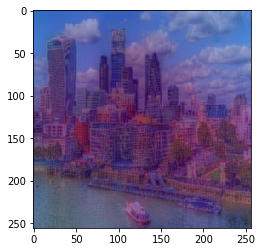

In [12]:
plt.imshow(img)
plt.show()